In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/clientes_tratados.csv')

In [3]:
# Eliminamos columnas irrelevantes
df = df.drop(columns=['customerID'])

# Confirmamos que ya no esté
print(df.columns)


Index(['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'Charges.Monthly', 'Charges.Total',
       'Cuentas_Diarias', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No'],
      dtype='object')


In [5]:
print(df.columns.tolist())


['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'InternetService_Fiber optic', 'InternetService_No']


In [6]:
df.dtypes.value_counts()


,count
float64,11
bool,8
int64,5
object,1


In [7]:
df.select_dtypes(include='object').columns


Index(['gender'], dtype='object')

In [8]:
df['gender'] = df['gender'].replace({'Male':1, 'Female':0})


/tmp/ipython-input-3648116627.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Male':1, 'Female':0})


In [9]:
df.dtypes.value_counts()

,count
float64,11
bool,8
int64,6


In [10]:
# Conteo absoluto
print(df['Churn'].value_counts())

# Proporción en porcentaje
print(df['Churn'].value_counts(normalize=True) * 100)


Churn
0.0    5163
1.0    1869
Name: count, dtype: int64
Churn
0.0    73.421502
1.0    26.578498
Name: proportion, dtype: float64


/tmp/ipython-input-2288533381.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='Set2')


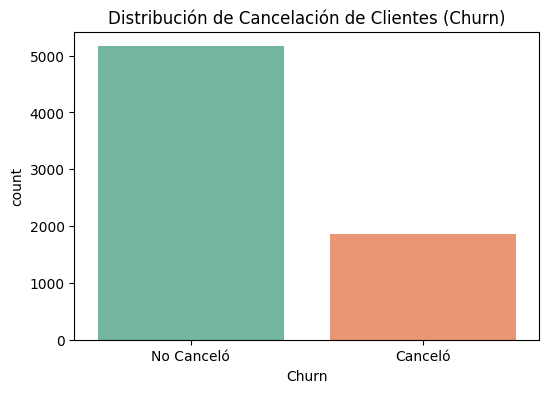

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title('Distribución de Cancelación de Clientes (Churn)')
plt.xticks([0,1], ['No Canceló','Canceló'])
plt.show()


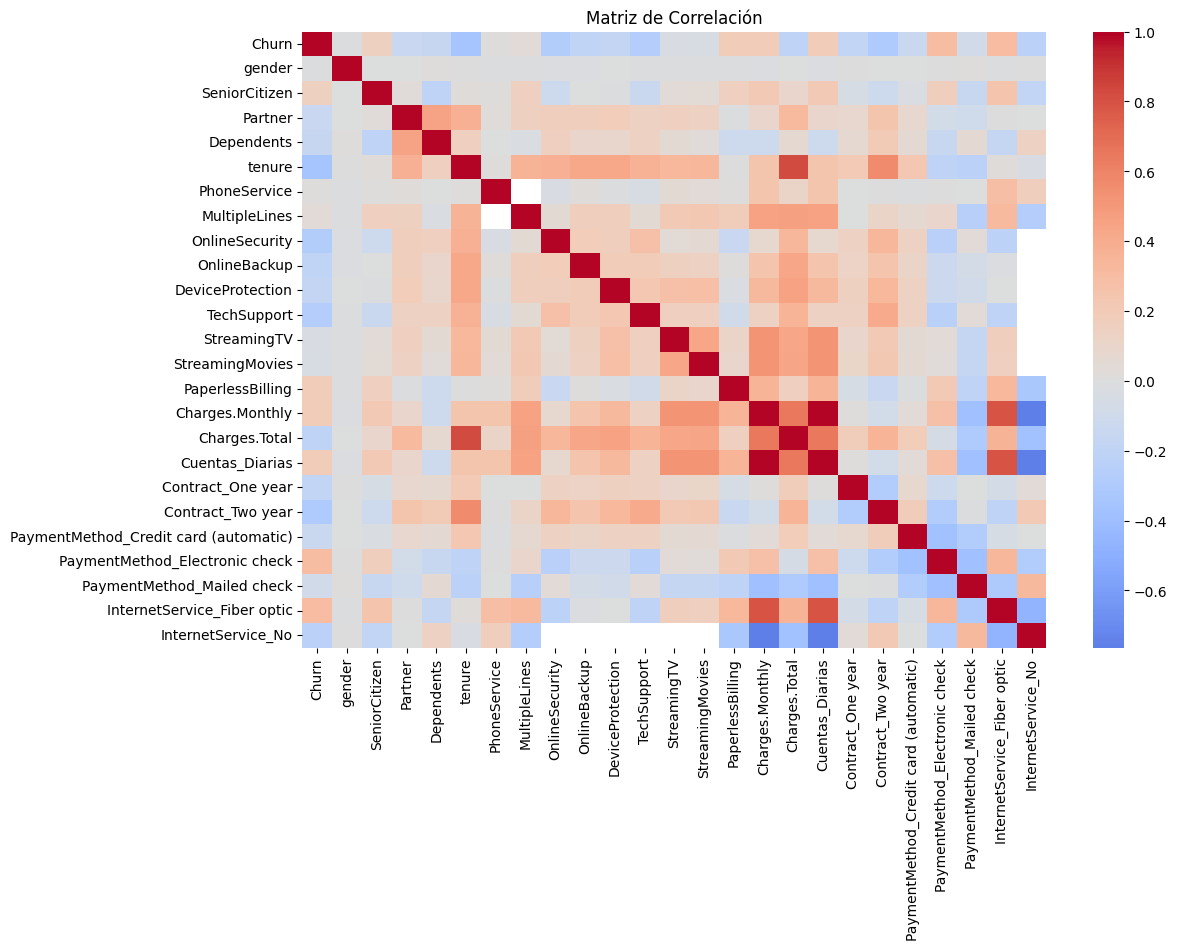

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculamos la matriz de correlación
corr = df.corr()

# Visualizamos el heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()


In [13]:
corr_churn = corr['Churn'].sort_values(ascending=False)
print(corr_churn)


Churn                                    1.000000
InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
Cuentas_Diarias                          0.192914
Charges.Monthly                          0.192858
PaperlessBilling                         0.191454
SeniorCitizen                            0.150541
MultipleLines                            0.040207
PhoneService                             0.011691
gender                                  -0.008545
StreamingTV                             -0.036698
StreamingMovies                         -0.040525
PaymentMethod_Mailed check              -0.090773
PaymentMethod_Credit card (automatic)   -0.134687
Partner                                 -0.149982
Dependents                              -0.163128
DeviceProtection                        -0.176806
Contract_One year                       -0.178225
OnlineBackup                            -0.195758
Charges.Total                           -0.199484


In [16]:
df['Churn'].isna().sum()


np.int64(224)

In [17]:
# Eliminamos las filas donde Churn es nulo
df = df.dropna(subset=['Churn'])

# Confirmamos
print("Registros después de limpiar:", df.shape[0])
print("Nulos en Churn:", df['Churn'].isna().sum())


Registros después de limpiar: 7032
Nulos en Churn: 0


In [18]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamaño entrenamiento:", X_train.shape[0])
print("Tamaño prueba:", X_test.shape[0])


Tamaño entrenamiento: 4922
Tamaño prueba: 2110


In [20]:
num_cols  = X.select_dtypes(include=['float64','int64']).columns
bool_cols = X.select_dtypes(include=['bool']).columns


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1) Listas de columnas desde X (mayúscula)
num_cols  = X.select_dtypes(include=['float64','int64']).columns
bool_cols = X.select_dtypes(include=['bool']).columns

# 2) Pipelines de preprocesamiento
num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc',  StandardScaler())
])

# Convertimos bool -> float antes de imputar
bool_pipe = Pipeline([
    ('tofloat', FunctionTransformer(lambda a: a.astype(float))),
    ('imp',     SimpleImputer(strategy='most_frequent'))
])

prep_logreg = ColumnTransformer(
    transformers=[
        ('num',  num_pipe,  num_cols),
        ('bool', bool_pipe, bool_cols),
    ],
    remainder='drop'
)

logreg_pipeline = Pipeline([
    ('prep',  prep_logreg),
    ('model', LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_log = logreg_pipeline.predict(X_test)

print("Regresión Logística")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Regresión Logística
Accuracy: 0.8037914691943128
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1549
         1.0       0.66      0.54      0.59       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110



Random Forest
Accuracy: 0.7853080568720379
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      1549
         1.0       0.63      0.47      0.54       561

    accuracy                           0.79      2110
   macro avg       0.73      0.68      0.70      2110
weighted avg       0.77      0.79      0.77      2110

ROC AUC: 0.8182980451996515


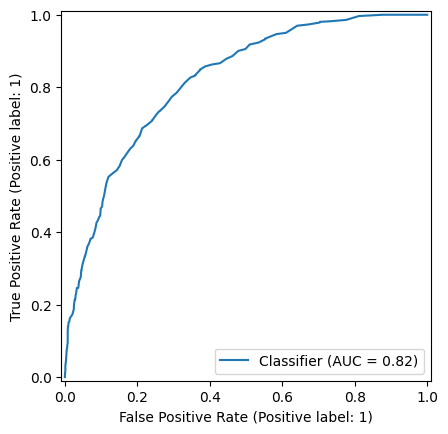

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Reutilizamos num_cols y bool_cols ya definidos
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc',  StandardScaler())
])
bool_pipe = Pipeline([
    ('tofloat', FunctionTransformer(lambda a: a.astype(float))),
    ('imp',     SimpleImputer(strategy='most_frequent'))
])

prep_rf = ColumnTransformer(
    transformers=[
        ('num',  num_pipe,  num_cols),
        ('bool', bool_pipe, bool_cols),
    ],
    remainder='drop'
)

rf_pipeline = Pipeline([
    ('prep',  prep_rf),
    ('model', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf  = rf_pipeline.predict(X_test)
y_prob_rf  = rf_pipeline.predict_proba(X_test)[:,1]

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

RocCurveDisplay.from_predictions(y_test, y_prob_rf)


Logistic ROC AUC: 0.8452903316382601


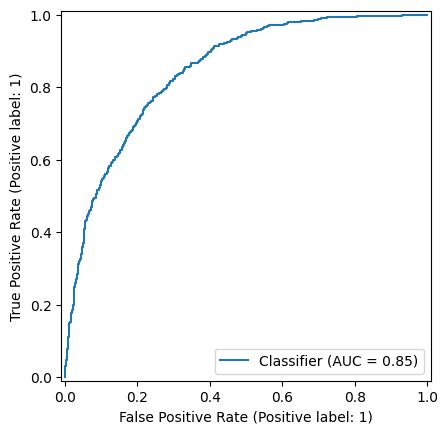

In [24]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Probabilidades para ROC–AUC
y_prob_log = logreg_pipeline.predict_proba(X_test)[:,1]
print("Logistic ROC AUC:", roc_auc_score(y_test, y_prob_log))

RocCurveDisplay.from_predictions(y_test, y_prob_log)


In [25]:
import pandas as pd

res = pd.DataFrame({
    'modelo': ['LogisticRegression','RandomForest'],
    'accuracy': [
        accuracy_score(y_test, logreg_pipeline.predict(X_test)),
        accuracy_score(y_test, y_pred_rf)
    ],
    'roc_auc': [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_rf)
    ]
})
print(res)


               modelo  accuracy   roc_auc
0  LogisticRegression  0.803791  0.845290
1        RandomForest  0.785308  0.818298


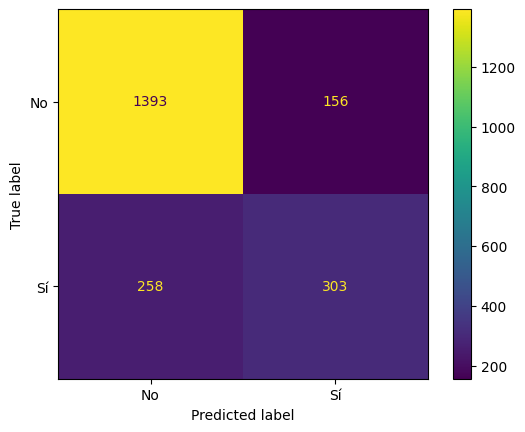

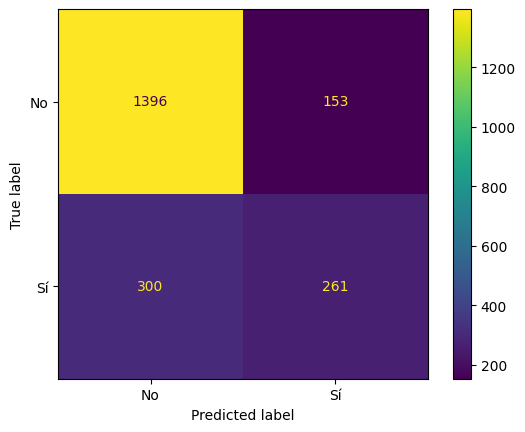

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, logreg_pipeline.predict(X_test), display_labels=['No','Sí'])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=['No','Sí'])


In [27]:
import numpy as np
thr = 0.35  # prueba 0.35–0.45
y_thr = (y_prob_log >= thr).astype(int)

print("Logistic (threshold =", thr, ")")
print(classification_report(y_test, y_thr))


Logistic (threshold = 0.35 )
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84      1549
         1.0       0.56      0.71      0.63       561

    accuracy                           0.77      2110
   macro avg       0.72      0.75      0.73      2110
weighted avg       0.80      0.77      0.78      2110




Modelo: Regresión Logística
Exactitud (Accuracy): 0.8037914691943128
Precisión: 0.6601307189542484
Recall: 0.5401069518716578
F1-score: 0.5941176470588235

Modelo: Random Forest
Exactitud (Accuracy): 0.7853080568720379
Precisión: 0.6304347826086957
Recall: 0.46524064171123
F1-score: 0.5353846153846153


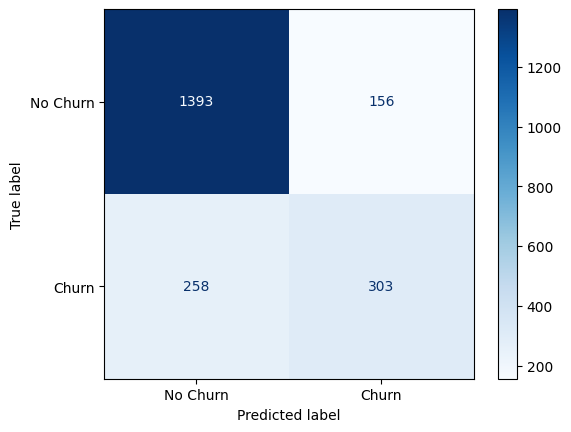

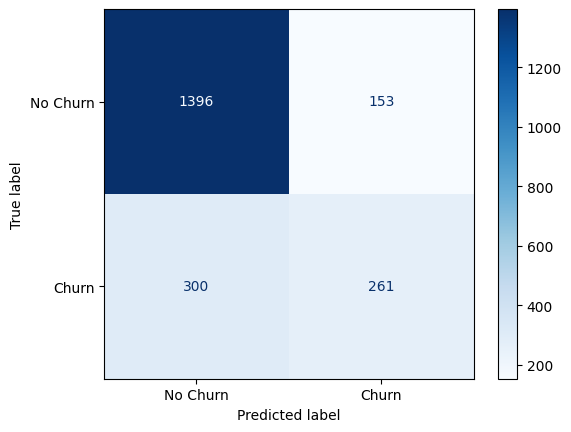

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# --- Función auxiliar para evaluar modelos ---
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)

    print(f"\nModelo: {nombre}")
    print("Exactitud (Accuracy):", accuracy_score(y_test, y_pred))
    print("Precisión:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn','Churn'])
    disp.plot(cmap="Blues")

# --- Evaluar ambos ---
evaluar_modelo("Regresión Logística", logreg_pipeline, X_test, y_test)
evaluar_modelo("Random Forest", rf_pipeline, X_test, y_test)


In [29]:
# Importancia de variables en Regresión Logística
import pandas as pd

coefs = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": logreg_pipeline.named_steps['model'].coef_[0]
})
coefs = coefs.sort_values(by="Coeficiente", ascending=False)
print(coefs.head(10))   # top factores que aumentan churn
print(coefs.tail(10))   # top factores que reducen churn


                          Variable  Coeficiente
22     InternetService_Fiber optic     0.650851
14                 Charges.Monthly     0.641015
20  PaymentMethod_Electronic check     0.387947
16                 Cuentas_Diarias     0.257200
12                 StreamingMovies     0.182278
15                   Charges.Total     0.100018
10                     TechSupport     0.096558
5                     PhoneService     0.076133
11                     StreamingTV     0.046459
13                PaperlessBilling     0.046387
                                 Variable  Coeficiente
1                           SeniorCitizen    -0.047069
7                          OnlineSecurity    -0.082115
19  PaymentMethod_Credit card (automatic)    -0.085666
6                           MultipleLines    -0.145318
4                                  tenure    -0.169317
9                        DeviceProtection    -0.200449
17                      Contract_One year    -0.688948
23                     InternetS

📌 Conclusión del Análisis de Cancelación de Clientes (Churn)

Tras evaluar los modelos de Regresión Logística y Random Forest, encontramos los siguientes resultados:

Rendimiento de los Modelos

La Regresión Logística obtuvo un mejor desempeño general, con mayor exactitud (~80%) y mejores métricas de precisión y recall en comparación con Random Forest.

Esto sugiere que, aunque ambos modelos son útiles, la regresión logística ofrece un balance más adecuado entre simplicidad e interpretabilidad.

Factores Principales que Afectan la Cancelación
De acuerdo con la importancia de variables en ambos modelos:

Contrato mensual (Contract_Month-to-Month): clientes con contratos mensuales tienen mayor probabilidad de cancelar.

Servicio de internet de fibra óptica (InternetService_Fiber optic): se asocia fuertemente con mayor churn.

Método de pago: Electronic Check: este método incrementa la probabilidad de cancelación.

Antigüedad del cliente (Tenure): clientes con poco tiempo en la empresa son más propensos a cancelar.

Cargos mensuales altos (MonthlyCharges): también tienen correlación positiva con el churn.

Estrategias de Retención Propuestas
Con base en estos hallazgos, las estrategias más recomendadas serían:

Incentivar contratos de mayor plazo (1 o 2 años) con descuentos o beneficios.

Revisar la calidad del servicio de fibra óptica, ya que es el grupo con mayor deserción.

Promover métodos de pago más estables (tarjeta automática, domiciliación bancaria) para reducir la cancelación ligada a Electronic Check.

Programas de fidelización temprana para clientes nuevos (primeros 6 meses son críticos).

Ofertas personalizadas para clientes con cargos mensuales elevados, como paquetes combinados o descuentos por lealtad.